In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt").read().splitlines()

In [3]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set("".join(words))))
stoi = {char: i+1 for i, char in enumerate(chars)}
stoi['.'] = 0
itos = {i: char for char, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:1]:
  
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .


In [7]:
# create training set:
def create_xy_samples(words: list[str]) -> tuple[list[torch.TensorType], list[torch.TensorType]]:
    xs, ys = [], []

    for w in words:
        context = [0] * block_size
        for char in w + '.':
            idx = stoi[char]
            xs.append(context)
            ys.append(idx)
            context = context[1:] + [idx]
        
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys

In [8]:
total_size = len(words)
train_size = int(total_size * 0.8)
valid_size = int(total_size * 0.1)
test_size = total_size - train_size - valid_size
(train_size, valid_size, test_size)

(25626, 3203, 3204)

In [9]:
shuffeld_words_idx = torch.randperm(len(words))

In [10]:
train_idx = shuffeld_words_idx[:train_size]
valid_idx = shuffeld_words_idx[train_size:(train_size+valid_size)]
test_idx = shuffeld_words_idx[(train_size+valid_size):]
test_idx.shape

torch.Size([3204])

In [11]:
train_words = [words[idx] for idx in train_idx]
valid_words = [words[idx] for idx in valid_idx]
test_words = [words[idx] for idx in test_idx]

In [12]:
Xtr, Ytr = create_xy_samples(train_words)
Xva, Yva = create_xy_samples(valid_words)
Xte, Yte = create_xy_samples(test_words)
Xtr.shape, Ytr.shape, Xva.shape, Yva.shape, Xte.shape, Yte.shape

(torch.Size([182464, 3]),
 torch.Size([182464]),
 torch.Size([22809, 3]),
 torch.Size([22809]),
 torch.Size([22873, 3]),
 torch.Size([22873]))

In [13]:
def printXYPairs(xs, ys, number_to_show):
    for x, y, in zip(xs[:number_to_show,:], ys[:number_to_show]):
        print("".join(itos[c.item()] for c in x) + " --> " + itos[y.item()])

In [14]:
printXYPairs(Xtr, Ytr, 20)

... --> v
..v --> i
.vi --> t
vit --> a
ita --> .
... --> r
..r --> o
.ro --> y
roy --> a
oya --> l
yal --> t
alt --> i
lti --> e
tie --> .
... --> d
..d --> a
.da --> y
day --> l
ayl --> i
yli --> a


### Create Embeddings

In [59]:
C = torch.randn((27,2))

In [61]:
X[0]

tensor([0, 0, 0])

In [65]:
C[X[:3]]

tensor([[[-0.4209,  1.9695],
         [-0.4209,  1.9695],
         [-0.4209,  1.9695]],

        [[-0.4209,  1.9695],
         [-0.4209,  1.9695],
         [-1.5184, -0.2580]],

        [[-0.4209,  1.9695],
         [-1.5184, -0.2580],
         [-0.0106,  1.1916]]])

In [66]:
emb = C[X]
emb.shape

torch.Size([5, 3, 2])

In [67]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])

In [70]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [76]:
emb.view(-1,6).shape

torch.Size([5, 6])

In [82]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [84]:
h.shape

torch.Size([5, 100])

In [85]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [89]:
logits = h @ W2 + b2

In [90]:
logits.shape

torch.Size([5, 27])

In [91]:
counts = logits.exp()

In [92]:
prob = counts / counts.sum(keepdim=True, dim=1)

In [93]:
prob.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [94]:
prob.shape

torch.Size([5, 27])

In [103]:
loss = -prob[torch.arange(5), Y].log().mean()
loss

tensor(16.8364)

In [25]:
def model_size(parameters):
    count = 0
    for p in parameters:
        count += p.nelement()
    print(f"model has {count} parameters")

In [131]:
Xtr.shape

torch.Size([182464, 3])

In [144]:
g = torch.Generator().manual_seed(2147483647)

number_of_characters = len(stoi)
embedding_size = 10
hidden_layer_size = 200
C = torch.randn((number_of_characters, embedding_size), generator=g)
W1 = torch.randn((block_size * embedding_size, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size, number_of_characters), generator=g)
b2 = torch.randn(number_of_characters, generator=g)
parameters = [C, W1, b1, W2, b2]

losses_tr = []
losses_val = []

for p in parameters:
    p.requires_grad = True

model_size(parameters)

model has 11897 parameters


In [145]:
def model_forward(X):
    emb = C[X]
    h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1)
    logits = h @ W2 + b2
    return logits

# training loop
nr_epochs = 200000
batch_size = 32
for epoch in range(nr_epochs):
    if epoch % 10000 == 0:
        print(epoch)
    idx = torch.randint(0, Xtr.shape[0], (batch_size,))
    logits = model_forward(Xtr[idx])
    loss = F.cross_entropy(logits, Ytr[idx])
    log_loss = loss.log10().item()
    # print(loss.item(), log_loss)
    losses_tr.append(log_loss)
    for p in parameters:
        p.grad = None

    # backward pass
    loss.backward()
    lr = 0.1 if epoch < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # with torch.no_grad():
    #     logits_val = model_forward(Xva)
    #     loss_val = F.cross_entropy(logits_val, Yva)
    #     log_loss_val = loss_val.log10().item()
    #     losses_val.append(log_loss_val)

0


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000


In [146]:
logits_val = model_forward(Xva)
loss_val = F.cross_entropy(logits_val, Yva)
print(loss_val.item())

2.131699562072754


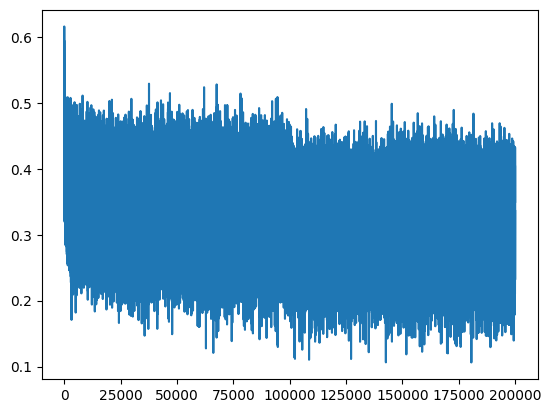

In [147]:
plt.plot(torch.arange(len(losses_tr)), losses_tr)
plt.plot(torch.arange(len(losses_val)), losses_val)

In [118]:
# sample from the model
for _ in range(20):
    word_idx = []
    context = [0] * 3
    while True:
        logits = model_forward(context)
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(input=probs[0], num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        word_idx.append(idx)
        if idx == 0:
            break
    print("".join([itos[i] for i in word_idx]))

junrde.
jana.
azha.
cory.
adin.
koitrino.
san.
jreck.
damnirayah.
leviai.
dedainr.
immogsnnn.
ean.
aren.
faruuntlyn.
demul.
phit.
len.
ruanlico.
aay.


In [86]:
# apply pca to C for visualization:
(U, S, V) = torch.pca_lowrank(C)

In [91]:
C.shape, U.shape, S.shape, V.shape

(torch.Size([27, 10]),
 torch.Size([27, 6]),
 torch.Size([6]),
 torch.Size([10, 6]))

In [108]:
pc = (C @ V[:,:2])

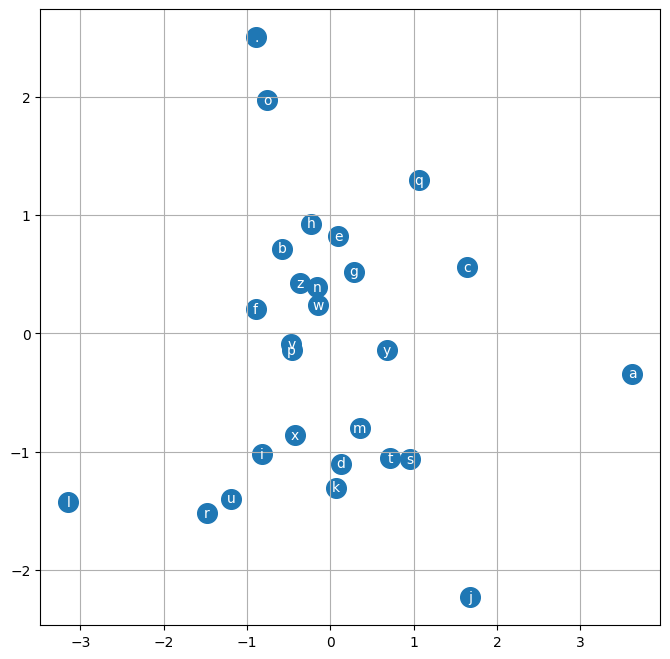

In [102]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(pc[:,0].data, pc[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(pc[i,0].item(), pc[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [120]:
g = torch.Generator().manual_seed(2147483647)

number_of_characters = len(stoi)
embedding_size = 10
hidden_layer_size = 200
C = torch.randn((number_of_characters, embedding_size))
W1 = torch.randn((block_size * embedding_size, hidden_layer_size))
b1 = torch.randn(hidden_layer_size)
W2 = torch.randn((hidden_layer_size, number_of_characters))
b2 = torch.randn(number_of_characters)
parameters = [C, W1, b1, W2, b2]

losses_tr = []
losses_val = []

for p in parameters:
    p.requires_grad = True

model_size(parameters)

model has 11897 parameters


In [128]:
def model_forward(X):
    emb = C[X]
    h = torch.relu(emb.view(-1, block_size * embedding_size) @ W1 + b1)
    logits = h @ W2 + b2
    return logits

# training loop
nr_epochs = 10000
batch_size = 64
for epoch in range(nr_epochs):
    if epoch % 100 == 0:
        print(epoch)
    idx = torch.randint(0, Xtr.shape[0], (batch_size,))
    logits = model_forward(Xtr[idx])
    loss = F.cross_entropy(logits, Ytr[idx])
    log_loss = loss.log10().item()
    # print(loss.item(), log_loss)
    losses_tr.append(log_loss)
    for p in parameters:
        p.grad = None

    # backward pass
    loss.backward()
    learning_rate = 0.01
    for p in parameters:
        p.data += -learning_rate * p.grad

    with torch.no_grad():
        logits_val = model_forward(Xva)
        loss_val = F.cross_entropy(logits_val, Yva)
        log_loss_val = loss_val.log10().item()
        losses_val.append(log_loss_val)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [129]:
logits_val = model_forward(Xva)
loss_val = F.cross_entropy(logits_val, Yva)
print(loss_val.item())

2.3832592964172363


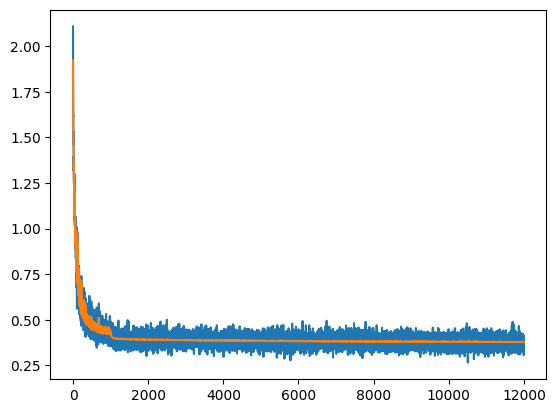

In [130]:
plt.plot(torch.arange(len(losses_tr)), losses_tr)
plt.plot(torch.arange(len(losses_val)), losses_val)

In [127]:
# sample from the model
for _ in range(20):
    word_idx = []
    context = [0] * 3
    while True:
        logits = model_forward(context)
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(input=probs[0], num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        word_idx.append(idx)
        if idx == 0:
            break
    print("".join([itos[i] for i in word_idx]))

juwide.
janasat.
presay.
acin.
koiin.
tolia.
satet.
kalinaa.
yanilenhas.
dbdainr.
imel.
sety.
eay.
arten.
nveumehin.
dtume.
phyns.
walesani.
cora.
yae.
